# Lab 7 - Logistic Regression, ROCs and imputation


In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
%matplotlib inline
import seaborn.apionly as sns

## Asymmetry

First we'd like to simply notice that our data set is very highly asymmetric, with positives, or people who churned, only making up 14-15% of the samples.

In [3]:
gssdata=pd.read_csv("gssdata4.csv")
gssdata.head()

,health,age,sex,educ,sexornt,partyid,race,married,income
0,excellent,53,male,16,heterosexual or straight,rep,white,1,18750.0
1,excellent,26,female,16,heterosexual or straight,rep,white,1,18750.0
2,good,59,male,13,heterosexual or straight,rep,white,1,NaN
3,excellent,74,female,17,heterosexual or straight,other,white,1,NaN
4,poor,37,female,10,heterosexual or straight,other,white,0,NaN


In [4]:
poorhealth = np.where(gssdata['health'] == 'poor',1,0)
excellenthealth = np.where(gssdata['health'] == 'excellent',1,0)
fairhealth = np.where(gssdata['health'] == 'fair',1,0)
gssdata['poorhealth'] = poorhealth
gssdata['fairhealth'] = fairhealth
gssdata['excellenthealth'] = excellenthealth
100*gssdata.poorhealth.mean()

6.382978723404255

 This means that a classifier which predicts EVERY respondent to not be in poor health will have an accuracy rate of 93-94%. 

But is accuracy the correct metric?  What may be a better measure of accuracy here?

## Fit a logistic model ignoring missingness

Let's begin by fitting a logistic regression model to predict poor health based on several of the other predictors in the model.  [in your HW, you will be asked to regularize (with Cross Validation) to make sure not to overfit to the data, but we will simploify things here.

First we need to do a small amount of data clean-up (ignoring missingness for now in income).  Best practiuce would be to split into train and test first before looking at the data, but again, we're simplifying it for illustrative purposes.

In [5]:
#creating dummies two ways
gssdata['female'] = 1*(gssdata['sex'] ==  'female')
dummy_vars = pd.get_dummies(gssdata[['sexornt','partyid','race']])
gssdata = gssdata.join(dummy_vars)

In [6]:
#Let's get a sense of the data we have
print(gssdata.shape)
gssdata.head()

(1551, 23)


,health,age,sex,educ,sexornt,partyid,race,married,income,poorhealth,...,sexornt_bisexual,sexornt_dont know,sexornt_heterosexual or straight,sexornt_homosexual or gay,partyid_dem,partyid_other,partyid_rep,race_black,race_other,race_white
0,excellent,53,male,16,heterosexual or straight,rep,white,1,18750.0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,excellent,26,female,16,heterosexual or straight,rep,white,1,18750.0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,good,59,male,13,heterosexual or straight,rep,white,1,NaN,0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,excellent,74,female,17,heterosexual or straight,other,white,1,NaN,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,poor,37,female,10,heterosexual or straight,other,white,0,NaN,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


---

## Handling missingness approach \#1: remove observations. 
We do not know how sklearn will treat the missing values (the \texttt{NaN}s), so we should do handle them ourselves.  As a base case, let's remove all observations with missingness.

In [7]:
#Note: don't be fooled by the name...this is the data set the only includes the 'full' aka 'complete' observations
gssdata_full = gssdata.dropna(how = 'any')
print(gssdata_full.shape)

# a quick check to see how dropping observations affected the amount of poor health individuals
print(100*gssdata_full.poorhealth.mean())
gssdata_full.head()

(963, 23)
1.66147455867


,health,age,sex,educ,sexornt,partyid,race,married,income,poorhealth,...,sexornt_bisexual,sexornt_dont know,sexornt_heterosexual or straight,sexornt_homosexual or gay,partyid_dem,partyid_other,partyid_rep,race_black,race_other,race_white
0,excellent,53,male,16,heterosexual or straight,rep,white,1,18750.0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,excellent,26,female,16,heterosexual or straight,rep,white,1,18750.0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5,excellent,30,female,15,heterosexual or straight,other,other,1,18750.0,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
9,excellent,30,female,14,heterosexual or straight,other,black,1,16250.0,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
12,good,38,female,15,heterosexual or straight,dem,white,0,18750.0,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [9]:
#Now we will split the data before fitting any models

from sklearn.model_selection import train_test_split
itrain, itest = train_test_split(range(gssdata_full.shape[0]), train_size=0.50)
#gsstemp = gssdata_full.drop(['health','fairhealth','goodhealth','excellenthealth','sex','sexornt','partyid','race'],axis=1)
gsstemp = gssdata_full[['age','educ','female','partyid_dem','partyid_rep','income']]
X_train = gsstemp.iloc[itrain, :]
X_test = gsstemp.iloc[itest, :]
y_train = gssdata_full['poorhealth'].iloc[itrain]
y_test = gssdata_full['poorhealth'].iloc[itest]

y_train.shape, X_train.shape, y_test.shape, X_test.shape

((481L,), (481, 6), (482L,), (482, 6))

In [10]:
#####################
# Your code here: fit a logistic model with C=1000000 and evaluate classification accuracy on the test set.
#####################
logit = LogisticRegression(C=1000000)
logit.fit(X_train, y_train) 
print(logit.score(X_test,y_test))

0.98132780083


## Remember the Confusion matrix? We reproduce it here for convenience

- the samples that are +ive and the classifier predicts as +ive are called True Positives (TP)
- the samples that are -ive and the classifier predicts (wrongly) as +ive are called False Positives (FP)
- the samples that are -ive and the classifier predicts as -ive are called True Negatives (TN)
- the samples that are +ive and the classifier predicts as -ive are called False Negatives (FN)

A classifier produces a confusion matrix which looks like this:

![confusionmatrix](./confusionmatrix_360.png)


IMPORTANT NOTE: In sklearn, to obtain the confusion matrix in the form above, always have the observed `y` first, i.e.: use as `confusion_matrix(y_true, y_pred)`



[[473   0]
 [  9   0]]


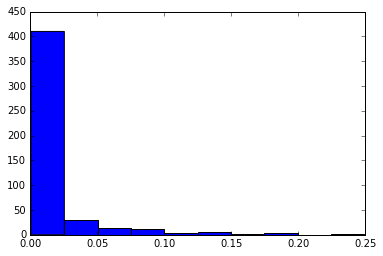

In [11]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,logit.predict(X_test)))
yhats = logit.predict_proba(X_train)
hist = plt.hist(yhats[:,1])

In [12]:
#manually making confusion table from a different threshold
def t_repredict(est, t, xtest):
    probs = est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred


In [13]:
#####################
# your code here: look at other thresholds for confusion matrix
#####################
print(confusion_matrix(y_test,t_repredict(logit, 0.06, X_test)))
print(confusion_matrix(y_train,t_repredict(logit, 0.06, X_train)))

[[448  25]
 [  9   0]]
[[446  28]
 [  3   4]]


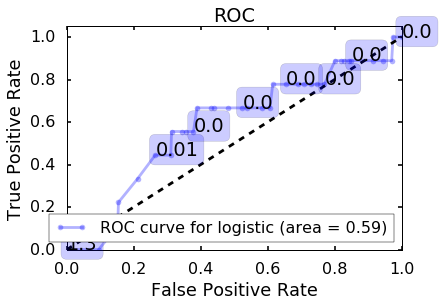

In [14]:
#making ROC curves for this model
from sklearn.metrics import roc_curve, auc

def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

sns.set_context("poster")
ax=make_roc("logistic",logit, y_test, X_test, labe=10, skip=2)

## Let's get back the data with missingness

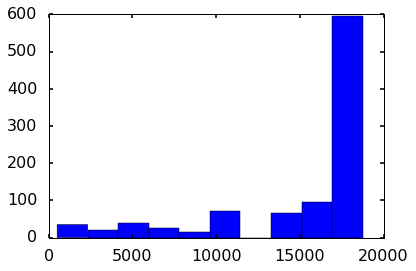

In [15]:
#first build a model to impute using data without missing 
hist = plt.hist(gssdata_full['income'])

---

## Handling missingness approach \#2: impute the mean 

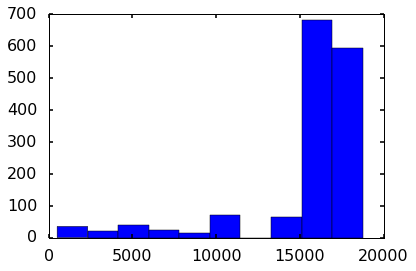

In [16]:
#back to the original data set with missingness, make a copy, and then impute the mean
gssdata2 = gssdata.copy()
gssdata2['income'] = gssdata['income'].fillna(gssdata_full['income'].mean())
hit = plt.hist(gssdata2['income'])

In [17]:
from sklearn.model_selection import train_test_split
itrain, itest = train_test_split(range(gssdata2.shape[0]), train_size=0.50)
#gsstemp = gssdata_full.drop(['health','fairhealth','goodhealth','excellenthealth','sex','sexornt','partyid','race'],axis=1)
gsstemp = gssdata2[['age','educ','female','partyid_dem','partyid_rep','income']]
X_train2 = gsstemp.iloc[itrain, :]
X_test2 = gsstemp.iloc[itest, :]
y_train2 = gssdata2['poorhealth'].iloc[itrain]
y_test2 = gssdata2['poorhealth'].iloc[itest]

y_train.shape, X_train.shape, y_test.shape, X_test.shape

logit2 = LogisticRegression(C=1000000)
logit2.fit(X_train2, y_train2) 
print(logit2.score(X_test2,y_test2))
logit2.coef_

0.935567010309


array([[  1.74109056e-02,  -1.89000983e-01,  -1.01922258e-02,
          8.85416474e-02,  -9.27316938e-02,  -6.62045352e-05]])

In [18]:
#####################
#your code here: create confusion tables
#####################
print(confusion_matrix(y_test2,t_repredict(logit2, 0.3, X_test2)))
print(confusion_matrix(y_train2,t_repredict(logit2, 0.3, X_train2)))

print(confusion_matrix(y_test2,t_repredict(logit2, 0.1, X_test2)))
print(confusion_matrix(y_train2,t_repredict(logit2, 0.1, X_train2)))

[[724   3]
 [ 46   3]]
[[721   4]
 [ 50   0]]
[[606 121]
 [ 26  23]]
[[609 116]
 [ 29  21]]


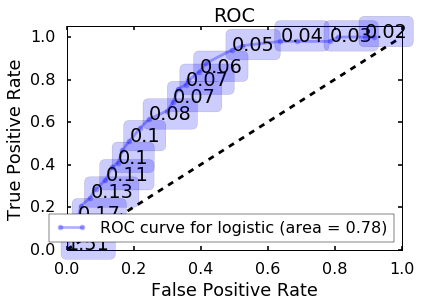

In [19]:
#####################
# your code here: create an ROC curve
#####################
sns.set_context("poster")
ax=make_roc("logistic",logit2, y_test2, X_test2, labe=10, skip=5)

---

## Handling missingness approach \#1: impute with a model (linear regression here) with uncertainty

In [20]:
#use the dataset without NAs to build a model
from sklearn.metrics import mean_squared_error

gssdata_full.head()

X_imp = gssdata_full[['age','educ','female','partyid_dem','partyid_rep']]
y_imp = gssdata_full['income']

from sklearn.linear_model import LinearRegression

regress = LinearRegression()
regress.fit(X_imp,y_imp)
y_hat = regress.predict(X_imp)

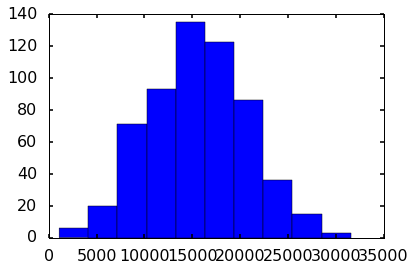

In [21]:
#####################
# your code here: 
# 1. figure out which observations have missing values for income,
# 2. create the values you will use for imputation by:
#  - calculating (1) the predicted yhats for the observations with missingness using the linear model 
#  - and then adding in error from the regression's residual distribution
# 3. use these values to impute back into the income variable in the missing entries
#####################
X_missing = gssdata[gssdata.income.isnull()][['age','educ','female','partyid_dem','partyid_rep']]
y_missing = regress.predict(X_missing)
y_missing_noise = y_missing+np.random.normal(loc=0,scale=np.sqrt(mean_squared_error(y_imp,y_hat)),size=y_missing.shape[0])

hit = plt.hist(y_missing_noise)

In [22]:
missing_index = gssdata.income[gssdata.income.isnull()].index
missing_series = pd.Series(data = y_missing_noise, index = missing_index)

In [23]:
#back to the data set with missingness and impute the predictions
gssdata_imp = gssdata.copy()

gssdata_imp['income'] = gssdata_imp['income'].fillna(missing_series)

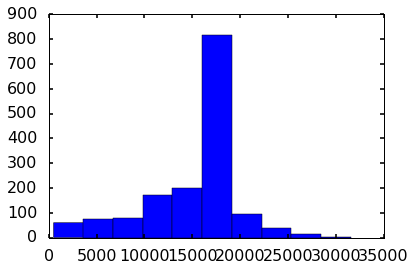

In [24]:
hist = plt.hist(gssdata_imp['income'])

In [25]:
gsstemp = gssdata_imp[['age','educ','female','partyid_dem','partyid_rep','income']]
X_train3 = gsstemp.iloc[itrain, :]
X_test3 = gsstemp.iloc[itest, :]
#y_train3 = gssdata_imp['poorhealth'].iloc[itrain]
#y_test3 = gssdata_imp['poorhealth'].iloc[itest]

y_train.shape, X_train.shape, y_test.shape, X_test.shape

logit3 = LogisticRegression(C=1000000)
logit3.fit(X_train3, y_train2) 
print(logit3.score(X_test3,y_test2))
logit3.coef_

0.938144329897


array([[  1.51577748e-02,  -2.13943276e-01,  -1.51939159e-02,
          4.79720929e-02,  -5.89634926e-02,  -3.79130106e-05]])

In [26]:
print(confusion_matrix(y_test2,t_repredict(logit3, 0.5, X_test3)))
print(confusion_matrix(y_train2,t_repredict(logit3, 0.5, X_train3)))

print(confusion_matrix(y_test2,t_repredict(logit3, 0.1, X_test3)))
print(confusion_matrix(y_train2,t_repredict(logit3, 0.1, X_train3)))

[[726   1]
 [ 47   2]]
[[724   1]
 [ 50   0]]
[[623 104]
 [ 27  22]]
[[613 112]
 [ 33  17]]


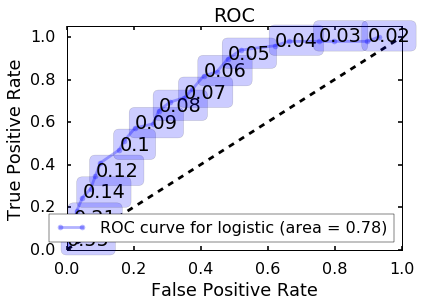

In [27]:
sns.set_context("poster")
ax=make_roc("logistic",logit3, y_test2, X_test3, labe=10, skip=5)